# $K$-symbols

## 0. Preliminary functions

We import some special functions that allow us to enumerate the $K$-rational points of a projective variety over a finite field and a function that defines a section of the reduction map $\mathcal{O}_K\rightarrow k$.

In [81]:
from sage.schemes.projective.projective_rational_point import enum_projective_finite_field
from sage.rings.padics.padic_generic import ResidueLiftingMap
from sage.schemes.elliptic_curves.weierstrass_morphism import *
import random
#from tqdm import tqdm

We define some combinatorial functions which will be useful (from itertools)

In [82]:
#from itertools import combinations
#from itertools import product

def product(*iterables, repeat=1):
    # product('ABCD', 'xy') → Ax Ay Bx By Cx Cy Dx Dy
    # product(range(2), repeat=3) → 000 001 010 011 100 101 110 111

    pools = [tuple(pool) for pool in iterables] * repeat

    result = [[]]
    for pool in pools:
        result = [x+[y] for x in result for y in pool]

    for prod in result:
        yield tuple(prod)
        
def combinations(iterable, r):
    # combinations('ABCD', 2) → AB AC AD BC BD CD
    # combinations(range(4), 3) → 012 013 023 123

    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))

    yield tuple(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield tuple(pool[i] for i in indices)

Below we make a list of the first `r` primes $p$ congruent to 3 modulo 4, excluding $p=3$.

In [83]:
def first_primes_3mod4(r):
    output = []
    for p in Primes():
        if p==3:
            continue
        if p%4==3:
            output.append(p)
            if len(output)>=r:
                break
    return output

In [84]:
first_primes_3mod4(16)

[7, 11, 19, 23, 31, 43, 47, 59, 67, 71, 79, 83, 103, 107, 127, 131]

We define `box_K` to be the "box" set $\{c_{-e}\pi^{-e}+\cdots c_e\pi^e\in K\mid c_i=0,\ldots,p-1\}$ of all elements $x_0\in K$ with $|\nu(x_0)|\leq e$, the absolute ramification index of $K$.

WARNING: This set has $p^{2e+1}$ elements.

In [85]:
def box_K(K):
    # Extract information from K
    preci = K(1).precision_absolute() # abs precision of K
    k = K.residue_field()
    char_k = k.characteristic() 
    pi = K.integer_ring().uniformiser()

    # Generate all pi-adic expansions
    coeffs = list(product(range(char_k), repeat=preci))
    full_list = []
    for c in coeffs:
        set_sum = [c[i]*pi^i for i in range(preci)]
        s = K(sum(set_sum))
        full_list.append(s)
    return full_list

In [86]:
def box_OK(K):
    # Extract information from K
    preci = K(1).precision_absolute() # abs precision of K
    k = K.residue_field()
    char_k = k.characteristic() 
    pi = K.integer_ring().uniformiser()

    # Generate all pi-adic expansions
    coeffs = list(product(range(char_k), repeat=preci))
    full_list = []
    for c in coeffs:
        set_sum = [c[i]*pi^i for i in range(preci)]
        s = K(sum(set_sum))
        full_list.append(s)
    return full_list

For example, for $K=\mathbb{Q}_7(\sqrt{7})$, we have:

In [87]:
# Takes about 30 sec
p = 7
x = polygen(ZZ, 'x')
K.<pi> = Qp(p,prec=3).extension(x^2 - p)
#box_K(K)

The function `box_K` is too slow, so we make a randomized version of it and make sure we hit all the valuations $|\nu(x)|\leq e$.

In [88]:
def random_box(K,reps):
    preci = K(1).precision_absolute()
    eK = K.absolute_e()
    k = K.residue_field()
    OK = K.integer_ring()
    v = OK.valuation()
    char_k = k.characteristic() 
    pi = OK.uniformiser()

    output = []

    for v in (-eK-1..eK+1):
        i = 0
        while i<reps:
            for c in (1..char_k-1):
                x = OK.random_element()
                y = c*pi^v+pi^(v+1)*x
                output.append(y)
                i+=1            
    return output

In [89]:
p = 7
x = polygen(ZZ, 'x')
K.<pi> = Qp(p,prec=3).extension(x^2 - p)
reps = 5

random_box(K,reps)

[pi^-3 + 5*pi^-2 + 2*pi^-1 + 6 + pi + 5*pi^2 + O(pi^3),
 2*pi^-3 + 6*pi^-2 + pi^-1 + 3 + 2*pi + pi^2 + O(pi^3),
 3*pi^-3 + 4*pi^-2 + pi^-1 + 5 + 6*pi + O(pi^3),
 4*pi^-3 + pi^-2 + 2*pi^-1 + 1 + pi + 6*pi^2 + O(pi^3),
 5*pi^-3 + 2*pi^-2 + 6*pi^-1 + 5 + 5*pi + 3*pi^2 + O(pi^3),
 6*pi^-3 + 6*pi^-2 + 5*pi^-1 + 1 + pi + O(pi^3),
 pi^-2 + 6*pi^-1 + 3*pi + 3*pi^3 + O(pi^4),
 2*pi^-2 + 4*pi^-1 + 6 + 3*pi + 3*pi^2 + 3*pi^3 + O(pi^4),
 3*pi^-2 + 6*pi^-1 + 3 + pi + 5*pi^3 + O(pi^4),
 4*pi^-2 + pi^-1 + 5 + 5*pi + 6*pi^2 + 6*pi^3 + O(pi^4),
 5*pi^-2 + 4*pi^-1 + 5*pi^2 + 3*pi^3 + O(pi^4),
 6*pi^-2 + 3*pi^-1 + 2*pi + 4*pi^2 + O(pi^4),
 pi^-1 + 6 + 3*pi + 2*pi^2 + 5*pi^3 + 5*pi^4 + O(pi^5),
 2*pi^-1 + 4 + 4*pi + pi^2 + 3*pi^4 + O(pi^5),
 3*pi^-1 + 4 + 4*pi + 4*pi^2 + O(pi^5),
 4*pi^-1 + 3 + 6*pi + 4*pi^2 + 2*pi^3 + 6*pi^4 + O(pi^5),
 5*pi^-1 + pi + 3*pi^2 + 6*pi^3 + 6*pi^4 + O(pi^5),
 6*pi^-1 + 1 + 3*pi + 6*pi^2 + 5*pi^3 + 4*pi^4 + O(pi^5),
 1 + 2*pi^2 + pi^3 + 4*pi^4 + O(pi^6),
 2 + 6*pi + pi^2 + 3*p

In [90]:
def thin_box(K):
    preci = K(1).precision_absolute()
    eK = K.absolute_e()
    k = K.residue_field()
    OK = K.integer_ring()
    v = OK.valuation()
    char_k = k.characteristic() 
    pi = OK.uniformiser()

    output = [K(0)]

    for v in (-eK-1..eK+1):
        for c in (1..char_k-1):
            x0 = K(c*pi^v)
            output.append(x0)      
    return output

In [91]:
p = 7
x = polygen(ZZ, 'x')
K.<pi> = Qp(p,prec=3).extension(x^2 - p)

thin_box(K)

[0,
 pi^-3 + O(pi^3),
 2*pi^-3 + O(pi^3),
 3*pi^-3 + O(pi^3),
 4*pi^-3 + O(pi^3),
 5*pi^-3 + O(pi^3),
 6*pi^-3 + O(pi^3),
 pi^-2 + O(pi^4),
 2*pi^-2 + O(pi^4),
 3*pi^-2 + O(pi^4),
 4*pi^-2 + O(pi^4),
 5*pi^-2 + O(pi^4),
 6*pi^-2 + O(pi^4),
 pi^-1 + O(pi^5),
 2*pi^-1 + O(pi^5),
 3*pi^-1 + O(pi^5),
 4*pi^-1 + O(pi^5),
 5*pi^-1 + O(pi^5),
 6*pi^-1 + O(pi^5),
 1 + O(pi^6),
 2 + O(pi^6),
 3 + O(pi^6),
 4 + O(pi^6),
 5 + O(pi^6),
 6 + O(pi^6),
 pi + O(pi^7),
 2*pi + O(pi^7),
 3*pi + O(pi^7),
 4*pi + O(pi^7),
 5*pi + O(pi^7),
 6*pi + O(pi^7),
 pi^2 + O(pi^8),
 2*pi^2 + O(pi^8),
 3*pi^2 + O(pi^8),
 4*pi^2 + O(pi^8),
 5*pi^2 + O(pi^8),
 6*pi^2 + O(pi^8),
 pi^3 + O(pi^9),
 2*pi^3 + O(pi^9),
 3*pi^3 + O(pi^9),
 4*pi^3 + O(pi^9),
 5*pi^3 + O(pi^9),
 6*pi^3 + O(pi^9)]

## 1. Producing pairs of supersingular Legendre form elliptic curves

We define `ss_lambdas` which takes a prime $p>3$ and returns the list $$\{\lambda\in \mathbb{F}_p\mid E_\lambda\;\text{is supersingular}\}$$

In [92]:
def ss_lambdas(p):
    k = GF(p)
    R.<x> = PolynomialRing(k)
    m = (p-1)/2
    f = sum([k(binomial(m,i)^2)*x^i for i in (0..m)])
    return [r[0] for r in f.roots()]

For example, for the first several primes $\equiv 3\pmod{4}$, we have

In [93]:
for p in first_primes_3mod4(15):
    li = ss_lambdas(p)
    print('p =',p,'has',len(li),'ssing lambdas:',ss_lambdas(p))

#[list(x) for x in product(ss_lambdas(p), repeat=2)]

p = 7 has 3 ssing lambdas: [6, 4, 2]
p = 11 has 3 ssing lambdas: [10, 6, 2]
p = 19 has 3 ssing lambdas: [18, 10, 2]
p = 23 has 9 ssing lambdas: [22, 21, 16, 13, 12, 11, 8, 3, 2]
p = 31 has 9 ssing lambdas: [30, 20, 19, 18, 16, 14, 13, 12, 2]
p = 43 has 3 ssing lambdas: [42, 22, 2]
p = 47 has 15 ssing lambdas: [46, 44, 41, 39, 36, 31, 27, 24, 21, 17, 12, 9, 7, 4, 2]
p = 59 has 9 ssing lambdas: [58, 52, 42, 37, 30, 23, 18, 8, 2]
p = 67 has 3 ssing lambdas: [66, 34, 2]
p = 71 has 21 ssing lambdas: [70, 67, 57, 53, 50, 49, 45, 43, 42, 38, 36, 34, 30, 29, 27, 23, 22, 19, 15, 5, 2]
p = 79 has 15 ssing lambdas: [78, 75, 73, 67, 64, 59, 46, 40, 34, 21, 16, 13, 7, 5, 2]
p = 83 has 9 ssing lambdas: [82, 66, 60, 45, 42, 39, 24, 18, 2]
p = 103 has 15 ssing lambdas: [102, 92, 79, 76, 74, 71, 61, 52, 43, 33, 30, 28, 25, 12, 2]
p = 107 has 9 ssing lambdas: [106, 103, 80, 65, 54, 43, 28, 5, 2]
p = 127 has 15 ssing lambdas: [126, 98, 93, 82, 79, 72, 70, 64, 58, 56, 49, 46, 35, 30, 2]


## 2. Producing Scholten Curves

Given a tuple $(a,b,c,d)\in K^4$ there are (at most) six genus 2 curves of the form
$$C: Y^2 = u (x^2-r)(x^2-s)(x^2-t)$$
equipped with a span
$$\sigma_1:C\rightarrow E_{a,b}:y^2=x(x-a)(x-b),\quad \sigma_1(x,y)=\left(u(x^2-v),uy\right)$$
$$\sigma_2:C\rightarrow E_{c,d}:y^2=x(x-c)(x-d),\quad \sigma_2(x,y)=\left(-urst(x^{-2}-r^{-1}),-urstx^{-3}y\right)$$
The formulas are given by the following table:
$$\begin{align*}
u &\mid& r &\mid& s &\mid& t &\mid& v\\
\frac{ab(a-b)}{ad-bc}&\mid& \frac{c-d}{a-b}&\mid& \frac{c}{a}&\mid& \frac{d}{b}& \mid&\frac{c-d}{a-b}\\
\frac{ab(a-b)}{ac-bd}&\mid& -\frac{c-d}{a-b}&\mid& \frac{c}{b}&\mid& \frac{d}{a}&\mid& -\frac{c-d}{a-b}\\
\frac{ab(a-b)}{ad-ac+bc}&\mid& -\frac{c-d}{b}&\mid& -\frac{d}{a-b}&\mid& -\frac{c}{a}&\mid& -\frac{d}{a-b}\\
\frac{ab(a-b)}{ac-ad+bd}&\mid& \frac{c-d}{b}&\mid& -\frac{c}{a-b}&\mid& -\frac{d}{a}&\mid& -\frac{c}{a-b}\\
\frac{ab(a-b)}{-ad-bc+bd}&\mid& \frac{c-d}{a}&\mid& \frac{c}{a-b}&\mid& -\frac{d}{b}&\mid& \frac{c}{a-b}\\
\frac{ab(a-b)}{-ac+bc-bd}&\mid& -\frac{c-d}{a}&\mid& \frac{d}{a-b}&\mid& -\frac{c}{b}&\mid& \frac{d}{a-b}
\end{align*}$$
Of these six curves, we discard those where $u$ is not a unit and those that do not have a Weierstrass point.

In [94]:
def spanning_curves(K,S_tuple):
    # Extract information about K and S_tuple
    precis = K(1).precision_absolute()
    A,B,C,D = S_tuple
    a = K(A).lift_to_precision()
    b = K(B).lift_to_precision()
    c = K(C).lift_to_precision()
    d = K(D).lift_to_precision()
    R.<x,y,z> = PolynomialRing(K)
    val = K.valuation()

    output = []

    denominator_check = [a*d-b*c,a*c-b*d,a*d-a*c+b*c,a*c-a*d+b*d,-a*d-b*c+b*d,-a*c+b*c-b*d]

    for i in (0..5):
        if val(denominator_check[i])>0:
            output.append([0,0,0,0,0,0,0])
        else:
            if i==0:
                u = a*b*(a-b)/(a*d-b*c); r = (c-d)/(a-b); s = c/a; t = d/b; v = (c-d)/(a-b)
            elif i==1:
                u = a*b*(a-b)/(a*c-b*d); r = -(c-d)/(a-b); s = c/b; t = d/a; v = -(c-d)/(a-b)
            elif i==2:
                u = a*b*(a-b)/(a*d-a*c+b*c); r = -(c-d)/b; s = -d/(a-b); t = -c/a; v = -d/(a-b)
            elif i==3:
                u = a*b*(a-b)/(a*c-a*d+b*d); r = (c-d)/b; s = -c/(a-b); t = -d/a; v = -c/(a-b)
            elif i==4:
                u = a*b*(a-b)/(-a*d-b*c+b*d); r = (c-d)/a; s = c/(a-b); t = -d/b; v = c/(a-b)
            elif i==5:
                u = a*b*(a-b)/(-b*d-a*c+b*c); r = -(c-d)/a; s = d/(a-b); t = -c/b; v = d/(a-b)

            if r.is_square() or s.is_square() or t.is_square():
                f = u*(x^2-r)*(x^2-s)*(x^2-t)
                f_hom = f.homogenize('z')
                C = Curve(f_hom-y^2*z^4)

                Eab = EllipticCurve(y^2-x*(x-a)*(x-b))
                Ecd = EllipticCurve(y^2-x*(x-c)*(x-d))

                hom_ab = C.Hom(Eab)
                hom_cd = C.Hom(Ecd)

                phi_1 = hom_ab([u*(x^2 - v*z^2),u*y*z,z^2])
                phi_2 = hom_cd([-u*r*s*t*(x*z^2-x^3*(r^(-1))),-u*r*s*t*y*z^2,x^3])

                #sigma11 = u*(x^2-v)
                #sigma12 = u*y
                #sigma21 = -u*r*s*t*(x^(-2)-r^(-1))
                #sigma22 = -u*r*s*t*y/x^3
                output.append([C,phi_1,phi_2,u,r,s,t])
            else:
                output.append([1,1,1,1,1,1,1])
    return output

Example: $K=\mathbb{Q}_7(\sqrt{7})$ and the pair $(\lambda,\mu)=(2+\pi^2,4-\pi)$.

In [95]:
p = 7
x = polygen(ZZ, 'x')
K.<pi> = Qp(p,prec=5).extension(x^2 - p)
k = K.residue_field()
OK = K.integer_ring()
pi = OK.uniformiser()

print('K =',K)
la = K(2+pi^2)
mu = K(4+pi)
S_tuple = [1,la,1,mu]
print('lambda =',la)
print('mu =',mu)
print('---------------------')
i = 1
for x in spanning_curves(K,S_tuple):
    #print('------------------------------')
    if x==[0,0,0,0,0,0,0]:
        print('C_',i,'= degenerates')
        print('---------------------')
    elif x==[1,1,1,1,1,1,1]:
        print('C_',i,'= has no Weierstrass points')
    else:
        print('C_',i,'=',x[0])
        print('u =',x[3])
        print('r =',x[4])
        print('s =',x[5])
        print('t =',x[6])
        print('---------------------')
    i+=1

K = 7-adic Eisenstein Extension Field in pi defined by x^2 - 7
lambda = 2 + pi^2 + O(pi^10)
mu = 4 + pi + O(pi^10)
---------------------
C_ 1 = Projective Plane Curve over 7-adic Eisenstein Extension Field in pi defined by x^2 - 7 defined by (6 + 4*pi + 2*pi^2 + O(pi^10))*x^6 + (6 + 2*pi + 5*pi^3 + 6*pi^4 + 6*pi^5 + 6*pi^6 + 6*pi^7 + 6*pi^8 + 6*pi^9 + O(pi^10))*x^4*z^2 + (3 + 4*pi + 4*pi^2 + pi^3 + O(pi^10))*x^2*z^4 - y^2*z^4 + (6 + 4*pi + 5*pi^2 + 6*pi^3 + 6*pi^4 + 6*pi^5 + 6*pi^6 + 6*pi^7 + 6*pi^8 + 6*pi^9 + O(pi^10))*z^6
u = 6 + 4*pi + 2*pi^2 + O(pi^10)
r = 3 + pi + 4*pi^2 + 6*pi^3 + 2*pi^4 + 4*pi^6 + 6*pi^7 + 2*pi^8 + O(pi^10)
s = 1 + O(pi^10)
t = 2 + 4*pi + 6*pi^2 + pi^3 + 3*pi^4 + 6*pi^5 + pi^6 + 3*pi^7 + 6*pi^8 + pi^9 + O(pi^10)
---------------------
C_ 2 = degenerates
---------------------
C_ 3 = Projective Plane Curve over 7-adic Eisenstein Extension Field in pi defined by x^2 - 7 defined by (1 + 4*pi + pi^2 + 4*pi^3 + 4*pi^4 + 6*pi^5 + 6*pi^7 + 4*pi^8 + pi^9 + O(pi^10))*x^6 +

## 3. Generating $K$-rational points on spanning curves

In [96]:
def quadratic_point_from_x0(K,C,x0):
    F = C.defining_polynomial()
    X,Y,Z = F.parent().gens()
    fx0 = F(x0,0,1)
    if fx0 == 0:
        y0 = 0
        output = C([x0,y0,1])
        #print('fx0 =',fx0)
        #print(' y0 =',y0)
    elif fx0.is_square():
        y0 = fx0.square_root()
        output = C([x0,y0,1])
        #print('fx0 =',fx0)
        #print(' y0 =',y0)
    else:
        #print('fx0 =',fx0)
        output = None
    return output

In [97]:
p = 7
x = polygen(ZZ, 'x')
K.<pi> = Qp(p,prec=2).extension(x^2 - p)
OK = K.integer_ring()
pi = OK.uniformiser()
k = K.residue_field()
reps = 20

ss_pairs = [list(x) for x in product(ss_lambdas(p), repeat=2)]
s = ss_pairs[1]
la = K(s[0]).lift_to_precision()+pi*OK.random_element()
mu = K(s[1]).lift_to_precision()+pi*OK.random_element()

S_tuple = [1,la,1,mu]
six_curves = spanning_curves(K,S_tuple)
i = 0
while i<6:
    if six_curves[i]==[0,0,0] or six_curves[i]==[1,1,1]:
        i += 1
    else:
        C = six_curves[i][0]
        break

print('lambda,mu =',la,',',mu)
print('Curve =',C,'\n')

for x0 in random_box(K,reps):
    print('x0 =',x0,'-----> P =',quadratic_point_from_x0(K,C,x0))
        

lambda,mu = 6 + 6*pi + 3*pi^2 + 3*pi^3 + O(pi^4) , 4 + 6*pi + 4*pi^3 + O(pi^4)
Curve = Projective Plane Curve over 7-adic Eisenstein Extension Field in pi defined by x^2 - 7 defined by (1 + 5*pi + O(pi^4))*x^6 + (1 + 4*pi + 5*pi^3 + O(pi^4))*x^4*z^2 + (4 + 5*pi + 2*pi^2 + 6*pi^3 + O(pi^4))*x^2*z^4 - y^2*z^4 + (1 + 4*pi^2 + pi^3 + O(pi^4))*z^6 

x0 = pi^-3 + 4*pi^-1 + 6 + O(pi) -----> P = (pi^-3 + 4*pi^-1 + 6 + O(pi) : pi^-9 + 6*pi^-8 + pi^-7 + 5*pi^-6 + O(pi^-5) : 1 + O(pi^4))
x0 = 2*pi^-3 + 5*pi^-1 + 4 + O(pi) -----> P = (2*pi^-3 + 5*pi^-1 + 4 + O(pi) : pi^-9 + 6*pi^-8 + pi^-7 + O(pi^-5) : 1 + O(pi^4))
x0 = 3*pi^-3 + 5*pi^-2 + pi^-1 + 1 + O(pi) -----> P = (3*pi^-3 + 5*pi^-2 + pi^-1 + 1 + O(pi) : pi^-9 + 4*pi^-8 + pi^-7 + 2*pi^-6 + O(pi^-5) : 1 + O(pi^4))
x0 = 4*pi^-3 + 4*pi^-2 + 3*pi^-1 + 1 + O(pi) -----> P = (4*pi^-3 + 4*pi^-2 + 3*pi^-1 + 1 + O(pi) : pi^-9 + 2*pi^-8 + 2*pi^-7 + O(pi^-5) : 1 + O(pi^4))
x0 = 5*pi^-3 + 5*pi^-1 + 5 + O(pi) -----> P = (5*pi^-3 + 5*pi^-1 + 5 + O(pi) : pi^-

## 4. Diagonal Signatures

In [98]:
def diagonal_signature(K,S_tuple,n):
    precis = K(1).precision_absolute()
    eK = K.absolute_e()
    k = K.residue_field()
    v = K.valuation()
    A,B,C,D = S_tuple
    a = K(A).lift_to_precision()
    b = K(B).lift_to_precision()
    c = K(C).lift_to_precision()
    d = K(D).lift_to_precision()
    R.<X,Y,Z> = PolynomialRing(K)

    curve_info = spanning_curves(K,S_tuple)

    i = 0
    while i<7:
        C_info = curve_info[i]
        if C_info==[0,0,0,0,0,0,0] or C_info==[1,1,1,1,1,1,1]:
            i+=1
            continue # skip degenerate curves
        
        C = C_info[0]
        
        if k(C_info[4]).is_square():
            wbar = k(C_info[4]).square_root()
            w = K(wbar).lift_to_precision()
        elif k(C_info[5]).is_square():
            wbar = k(C_info[5]).square_root()
            w = K(wbar).lift_to_precision()
        else:
            wbar = k(C_info[6]).square_root()
            w = K(wbar).lift_to_precision()

        f = C.defining_polynomial()
        F = pi^(2*n)-f(x,0,1)
        x_coord = F.hensel_lift(w)

        P = quadratic_point_from_x0(K,C,x_coord)

        phi1 = C_info[1]
        phi2 = C_info[2]
        E1 = phi1.codomain(); E1_bar = E1.change_ring(k)
        E2 = phi2.codomain(); E2_bar = E2.change_ring(k)
        phi11,phi12,phi13 = phi1.defining_polynomials()
        phi21,phi22,phi23 = phi2.defining_polynomials()

        x0 = P[0]; y0 = P[1]; z0 = P[2]
        x1 = phi11(x0,y0,z0); y1 = phi12(x0,y0,z0); z1 = phi13(x0,y0,z0)
        x2 = phi21(x0,y0,z0); y2 = phi22(x0,y0,z0); z2 = phi23(x0,y0,z0)

        P1 = E1([x1,y1,z1])
        P2 = E2([x2,y2,z2])

        if v(P1[0])>=0:
            n1 = E1_bar(P1).order()
            P1_hat = n1*P1
        else:
            P1_hat = P1
            n1 = 1

        if v(P2[0])>=0:
            n2 = E2_bar(P2).order()
            P2_hat = n2*P2
        else:
            P2_hat = P2
            n2 = 1
            
        pi_adic_exp_of_P1_hat = -P1_hat[0]/P1_hat[1]
        pi_adic_exp_of_P2_hat = -P2_hat[0]/P2_hat[1]

        s1 = eK*v(pi_adic_exp_of_P1_hat)
        s2 = eK*v(pi_adic_exp_of_P2_hat)

        output = [C,P,[P1,n1],[P2,n2],[P1_hat,pi_adic_exp_of_P1_hat],[P2_hat,pi_adic_exp_of_P2_hat],[s1,s2]]
        break
    
    return output

In [99]:
p = 7
x = polygen(ZZ, 'x')
K.<pi> = Qp(p,prec=3).extension(x^2 - p)
OK = K.integer_ring()
pi = OK.uniformiser()
k = K.residue_field()
n=2

ss_pairs = [list(x) for x in product(ss_lambdas(p), repeat=2)]
j = ZZ.random_element(0, len(ss_pairs))
s = ss_pairs[j]
la = K(s[0]).lift_to_precision()+pi*OK.random_element()
mu = K(s[1]).lift_to_precision()+pi*OK.random_element()

S_tuple = [1,la,1,mu]
print('lambda =',la)
print('mu =',mu)

out = diagonal_signature(K,S_tuple,n)
print('C =',out[0])
print('P =',out[1])
print('P1 =',out[2][0])
print('n1 =',out[2][1])
print('P2 =',out[3][0])
print('n2 =',out[3][1])
print('P1_hat =',out[4][0])
print('P2_hat =',out[5][0])
print('s =',out[6])

lambda = 2 + 4*pi^3 + 6*pi^4 + 5*pi^5 + O(pi^6)
mu = 4 + 6*pi + 5*pi^3 + 2*pi^4 + 2*pi^5 + O(pi^6)
C = Projective Plane Curve over 7-adic Eisenstein Extension Field in pi defined by x^2 - 7 defined by (6 + 3*pi + 4*pi^2 + 4*pi^3 + 5*pi^4 + 4*pi^5 + O(pi^6))*x^6 + (6 + 5*pi + 6*pi^2 + pi^3 + pi^4 + 4*pi^5 + O(pi^6))*x^4*z^2 + (3 + 3*pi + 6*pi^2 + 2*pi^3 + 3*pi^4 + pi^5 + O(pi^6))*x^2*z^4 - y^2*z^4 + (6 + 3*pi + 2*pi^2 + 5*pi^3 + 2*pi^4 + 3*pi^5 + O(pi^6))*z^6
P = (1 + 5*pi^4 + 6*pi^5 + O(pi^6) : pi^2 + O(pi^4) : 1 + O(pi^6))
P1 = (2 + 4*pi^3 + 3*pi^4 + 2*pi^5 + O(pi^6) : 6*pi^2 + 3*pi^3 + O(pi^4) : 1 + O(pi^6))
n1 = 2
P2 = (4 + 6*pi + 5*pi^3 + 5*pi^4 + 5*pi^5 + O(pi^6) : 6*pi^2 + 3*pi^3 + O(pi^4) : 1 + O(pi^6))
n2 = 2
P1_hat = (pi^-4 + 6*pi^-3 + O(pi^-2) : pi^-6 + 2*pi^-5 + O(pi^-4) : 1 + O(pi^6))
P2_hat = (pi^-4 + 6*pi^-3 + O(pi^-2) : 6*pi^-6 + 5*pi^-5 + O(pi^-4) : 1 + O(pi^6))
s = [2, 2]


## 5. Computing Signatures

In [100]:
def signatures_from_box(K,S_tuple,box,full_info=False):
    precis = K(1).precision_absolute()
    eK = K.absolute_e()
    k = K.residue_field()
    v = K.valuation()
    A,B,C,D = S_tuple
    a = K(A).lift_to_precision()
    b = K(B).lift_to_precision()
    c = K(C).lift_to_precision()
    d = K(D).lift_to_precision()
    R.<X,Y,Z> = PolynomialRing(K)

    curve_info = spanning_curves(K,S_tuple)

    all_sigs = []
    full_output = []

    for j in curve_info:
        if j==[0,0,0,0,0,0,0] or j==[1,1,1,1,1,1,1]:
            continue # skip degenerate curves
        
        C = j[0]
        phi1 = j[1]
        phi2 = j[2]
        Eab = phi1.codomain(); Eab_bar = Eab.change_ring(k)
        Ecd = phi2.codomain(); Ecd_bar = Ecd.change_ring(k)
        phi11,phi12,phi13 = phi1.defining_polynomials()
        phi21,phi22,phi23 = phi2.defining_polynomials()

        pts = [quadratic_point_from_x0(K,C,X0) for X0 in box if quadratic_point_from_x0(K,C,X0)!=None]

        for P in pts:
            x0 = P[0]; y0 = P[1]; z0 = P[2]
            x1 = phi11(x0,y0,z0); y1 = phi12(x0,y0,z0); z1 = phi13(x0,y0,z0)
            x2 = phi21(x0,y0,z0); y2 = phi22(x0,y0,z0); z2 = phi23(x0,y0,z0)
            try:
                P1 = Eab([x1,y1,z1])
                P2 = Ecd([x2,y2,z2])
            except TypeError: # Sometimes points don't land on the elliptic curves...
                continue

            if v(P1[0])>=0:
                n1 = Eab_bar(P1).order()
                P1_hat = n1*P1
            else:
                P1_hat = P1
                n1 = 1

            if v(P2[0])>=0:
                n2 = Ecd_bar(P2).order()
                P2_hat = n2*P2
            else:
                P2_hat = P2
                n2 = 1
            
            pi_adic_exp_of_P1_hat = -P1_hat[0]/P1_hat[1]
            pi_adic_exp_of_P2_hat = -P2_hat[0]/P2_hat[1]

            s1 = eK*v(pi_adic_exp_of_P1_hat)
            s2 = eK*v(pi_adic_exp_of_P2_hat)

            all_sigs.append((s1,s2))
            full_output.append([C,P,[P1,n1],[P2,n2],[P1_hat,pi_adic_exp_of_P1_hat],[P2_hat,pi_adic_exp_of_P2_hat],[s1,s2]])

    if not full_info:
        output = sorted(list(set(all_sigs)))
    else:
        output = full_output

    return output

Example: $K=\mathbb{Q}_7(\sqrt{7})$

In [101]:
p = 7
x = polygen(ZZ, 'x')
K.<pi> = Qp(p,prec=3).extension(x^2 - p)
OK = K.integer_ring()
pi = OK.uniformiser()
k = K.residue_field()
box = thin_box(K)

ss_pairs = [list(x) for x in product(ss_lambdas(p), repeat=2)]
j = ZZ.random_element(0, len(ss_pairs))
s = ss_pairs[j]
la = K(s[0]).lift_to_precision()+pi*OK.random_element()
mu = K(s[1]).lift_to_precision()+pi*OK.random_element()

S_tuple = [1,la,1,mu]
print('lambda,mu =',la,',',mu)
print(signatures_from_box(K,S_tuple,box,full_info=False))

lambda,mu = 6 + 2*pi + 6*pi^2 + 3*pi^3 + 4*pi^4 + 3*pi^5 + O(pi^6) , 4 + 3*pi + 2*pi^2 + pi^3 + 6*pi^4 + 6*pi^5 + O(pi^6)
[(1, 1), (1, 2), (1, 3), (1, +Infinity), (2, 1), (3, 1), (+Infinity, +Infinity)]


Example: $K=\mathbb{Q}_7(\sqrt{7})$ and the pair $(\lambda,\mu)=(2+\pi^2,4-\pi)$.

In [102]:
p = 7
x = polygen(ZZ, 'x')
K.<pi> = Qp(p,prec=5).extension(x^2 - p)
k = K.residue_field()
OK = K.integer_ring()
pi = OK.uniformiser()
box = thin_box(K)
eK = K.absolute_e()

print('K =',K)
la = K(2+pi^2)
mu = K(4+pi)
S_tuple = [1,la,1,mu]
print('lambda =',la)
print('mu =',mu)
print('---------------------')
out = signatures_from_box(K,S_tuple,box,full_info=True)

for x in out:
    print('C =',x[0])
    print('P =',x[1])
    print('P1 =',x[2][0])
    print('n1 =',x[2][1])
    print('P2 =',x[3][0])
    print('n2 =',x[3][1])
    print('P1_hat =',x[4][0])
    print('P2_hat =',x[5][0])
    print('s =',x[6])
    print('----------------------------------------------------------')

K = 7-adic Eisenstein Extension Field in pi defined by x^2 - 7
lambda = 2 + pi^2 + O(pi^10)
mu = 4 + pi + O(pi^10)
---------------------
C = Projective Plane Curve over 7-adic Eisenstein Extension Field in pi defined by x^2 - 7 defined by (6 + 4*pi + 2*pi^2 + O(pi^10))*x^6 + (6 + 2*pi + 5*pi^3 + 6*pi^4 + 6*pi^5 + 6*pi^6 + 6*pi^7 + 6*pi^8 + 6*pi^9 + O(pi^10))*x^4*z^2 + (3 + 4*pi + 4*pi^2 + pi^3 + O(pi^10))*x^2*z^4 - y^2*z^4 + (6 + 4*pi + 5*pi^2 + 6*pi^3 + 6*pi^4 + 6*pi^5 + 6*pi^6 + 6*pi^7 + 6*pi^8 + 6*pi^9 + O(pi^10))*z^6
P = (1 + O(pi^10) : 0 : 1 + O(pi^10))
P1 = (2 + pi^2 + O(pi^10) : 0 : 1 + O(pi^10))
n1 = 2
P2 = (4 + pi + O(pi^10) : 0 : 1 + O(pi^10))
n2 = 2
P1_hat = (0 : 1 + O(pi^10) : 0)
P2_hat = (0 : 1 + O(pi^10) : 0)
s = [+Infinity, +Infinity]
----------------------------------------------------------
C = Projective Plane Curve over 7-adic Eisenstein Extension Field in pi defined by x^2 - 7 defined by (6 + 4*pi + 2*pi^2 + O(pi^10))*x^6 + (6 + 2*pi + 5*pi^3 + 6*pi^4 + 6*pi^5 + 6*p

Missing diagonal signature:

In [103]:
p = 7
x = polygen(ZZ, 'x')
K.<pi> = Qp(p,prec=5).extension(x^2 - p)
k = K.residue_field()
OK = K.integer_ring()
pi = OK.uniformiser()

la = K(2+pi^2)
mu = K(4+pi)
S_tuple = [1,la,1,mu]
span = spanning_curves(K,S_tuple)[4]
C = span[0]

f = C.defining_polynomial()
F = pi^4-f(x,0,1)
x_coord = F.hensel_lift(2)

P = quadratic_point_from_x0(K,C,x_coord)

out = diagonal_signature(K,S_tuple,2)
print('C =',out[0])
print('P =',out[1])
print('P1 =',out[2][0])
print('P2 =',out[3][0])
print('signature =',out[6])

C = Projective Plane Curve over 7-adic Eisenstein Extension Field in pi defined by x^2 - 7 defined by (6 + 4*pi + 2*pi^2 + O(pi^10))*x^6 + (6 + 2*pi + 5*pi^3 + 6*pi^4 + 6*pi^5 + 6*pi^6 + 6*pi^7 + 6*pi^8 + 6*pi^9 + O(pi^10))*x^4*z^2 + (3 + 4*pi + 4*pi^2 + pi^3 + O(pi^10))*x^2*z^4 - y^2*z^4 + (6 + 4*pi + 5*pi^2 + 6*pi^3 + 6*pi^4 + 6*pi^5 + 6*pi^6 + 6*pi^7 + 6*pi^8 + 6*pi^9 + O(pi^10))*z^6
P = (1 + 5*pi^4 + pi^5 + 3*pi^6 + 2*pi^7 + 5*pi^8 + pi^9 + O(pi^10) : pi^2 + O(pi^8) : 1 + O(pi^10))
P1 = (2 + pi^2 + 4*pi^4 + 3*pi^5 + 2*pi^6 + 3*pi^7 + 3*pi^8 + 4*pi^9 + O(pi^10) : 6*pi^2 + 4*pi^3 + 2*pi^4 + O(pi^8) : 1 + O(pi^10))
P2 = (4 + pi + 3*pi^4 + 4*pi^5 + 2*pi^6 + 5*pi^8 + 2*pi^9 + O(pi^10) : 6*pi^2 + 4*pi^3 + 5*pi^4 + 6*pi^5 + 5*pi^7 + O(pi^8) : 1 + O(pi^10))
signature = [2, 2]


In [120]:
p = 11
x = polygen(ZZ, 'x')
K.<pi> = Qp(p,prec=5).extension(x^2 - p)
k = K.residue_field()
OK = K.integer_ring()
pi = OK.uniformiser()
box = thin_box(K)
eK = K.absolute_e()

print('K =',K)
la = K(10)
mu = K(2)
S_tuple = [1,la,1,mu]
print('lambda =',la)
print('mu =',mu)
print('---------------------')
out = signatures_from_box(K,S_tuple,box,full_info=True)

for x in out:
    print('C =',x[0])
    print('P =',x[1])
    print('P1 =',x[2][0])
    print('n1 =',x[2][1])
    print('P2 =',x[3][0])
    print('n2 =',x[3][1])
    print('P1_hat =',x[4][0])
    print('P2_hat =',x[5][0])
    print('s =',x[6])
    print('----------------------------------------------------------')

K = 11-adic Eisenstein Extension Field in pi defined by x^2 - 11
lambda = 10 + O(pi^10)
mu = 2 + O(pi^10)
---------------------
C = Projective Plane Curve over 11-adic Eisenstein Extension Field in pi defined by x^2 - 11 defined by (3 + 9*pi^2 + 2*pi^4 + 8*pi^6 + 2*pi^8 + O(pi^10))*x^6 + (10 + 6*pi^2 + 2*pi^4 + 8*pi^6 + 2*pi^8 + O(pi^10))*x^4*z^2 + (1 + 3*pi^2 + 8*pi^4 + 2*pi^6 + 8*pi^8 + O(pi^10))*x^2*z^4 - y^2*z^4 + (8 + 2*pi^2 + 8*pi^4 + 2*pi^6 + 8*pi^8 + O(pi^10))*z^6
P = (pi^-3 + O(pi^7) : 5*pi^-9 + 4*pi^-7 + 6*pi^-5 + 4*pi^-3 + pi^-1 + O(pi) : 1 + O(pi^10))
P1 = (3*pi^-6 + 9*pi^-4 + 2*pi^-2 + 4 + 5*pi^2 + O(pi^4) : 4*pi^-9 + 3*pi^-7 + 3*pi^-5 + 10*pi^-3 + 4*pi^-1 + O(pi) : 1 + O(pi^10))
n1 = 1
P2 = (5 + 8*pi^2 + 2*pi^4 + 5*pi^6 + 5*pi^8 + O(pi^10) : 7 + pi^2 + pi^4 + 7*pi^6 + 10*pi^8 + O(pi^10) : 1 + O(pi^10))
n2 = 3
P1_hat = (3*pi^-6 + 9*pi^-4 + 2*pi^-2 + 4 + 5*pi^2 + O(pi^4) : 4*pi^-9 + 3*pi^-7 + 3*pi^-5 + 10*pi^-3 + 4*pi^-1 + O(pi) : 1 + O(pi^10))
P2_hat = (9*pi^-4 + pi^-2 + 6

We compute the signatures that arise from all quadratic ramified extensions of $\mathbb{Q}_p$ for the primes $\{7,11,19\}$, these are congruent to 3 modulo 4 and have few supersingular elliptic curves defined over $\mathbb{F}_p$. (only for $\lambda,\mu\in\mathbb{Z}$)

In [104]:
prime_list = [7,11,19]
x = polygen(ZZ, 'x')

for p in prime_list:
    print('>>>>>>>>>>>>>>>>>>>> p =',p,'<<<<<<<<<<<<<<<<<<<<')
    for sgn in [-1,1]:
        K.<pi> = Qp(p,prec=5).extension(x^2 + sgn*p)
        OK = K.integer_ring()
        pi = OK.uniformiser()
        box = thin_box(K)
        print('K =',K)
        for s in [list(x) for x in product(ss_lambdas(p), repeat=2)]:
            la = K(s[0]).lift_to_precision()
            mu = K(s[1]).lift_to_precision()
            S_tuple = [1,la,1,mu]
            try:
                sigs = signatures_from_box(K,S_tuple,box,full_info=False)
                print(s,'-->',sigs)
            except TypeError:
                print(s,'--> did not work')
                continue
        print('\n')

>>>>>>>>>>>>>>>>>>>> p = 7 <<<<<<<<<<<<<<<<<<<<
K = 7-adic Eisenstein Extension Field in pi defined by x^2 - 7
[6, 6] --> [(1, 1), (1, 2), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (2, +Infinity), (3, 2), (4, 1)]
[6, 4] --> [(1, 1), (1, 2), (1, 4), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, +Infinity), (3, 2), (4, 2), (+Infinity, +Infinity)]
[6, 2] --> [(1, 1), (1, 2), (2, 1), (2, 2), (2, 3), (2, 4), (2, 6), (2, 8), (2, +Infinity), (3, 2), (3, 4), (4, 1), (6, 1), (+Infinity, +Infinity)]
[4, 6] --> [(1, 1), (1, 2), (2, 1), (2, 2), (2, 3), (2, 4), (2, +Infinity), (3, 2), (4, 1), (+Infinity, +Infinity)]
[4, 4] --> [(1, 1), (1, 2), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (2, +Infinity), (3, 2), (3, 4), (4, 1), (4, 2), (4, 3), (4, +Infinity), (+Infinity, +Infinity)]
[4, 2] --> [(1, 1), (1, 2), (1, 4), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, +Infinity), (3, 2), (4, 1), (+Infinity, +Infinity)]
[2, 6] --> [(1, 1), (1, 2), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (2, +Infinity), (3, 2), (4, 2

For all quadratic ramified extensions of $\mathbb{Q}_p$ for the primes $\{7,11,19,43,67\}$ we count how many pairs $(\lambda,\mu)\in\{2,3,\ldots,p-1\}$, where $E_\lambda,E_\mu$ have supersingular reduction, generate the signatures (1,1),(1,2),(2,1) and (2,2).

In [105]:
prime_list = [7,11,19,43,67] # 41sec
x = polygen(ZZ, 'x')

for p in prime_list:
    print('>>>>>>>>>>>>>>>>>>>> p =',p,'<<<<<<<<<<<<<<<<<<<<')
    for sgn in [-1,1]:
        K.<pi> = Qp(p,prec=5).extension(x^2 + sgn*p)
        OK = K.integer_ring()
        pi = OK.uniformiser()
        box = thin_box(K)
        pairs = [list(x) for x in product(ss_lambdas(p), repeat=2)]
        good_pairs = 0
        total_pairs = len(pairs) 
        for s in pairs:
            la = K(s[0]).lift_to_precision()#+pi*OK.random_element()
            mu = K(s[1]).lift_to_precision()#+pi*OK.random_element()
            S_tuple = [1,la,1,mu]
            sigs = signatures_from_box(K,S_tuple,box,full_info=False)
            if set([(1,1),(1,2),(2,1)]) <= set(sigs):
                good_pairs += 1
            else:
                continue
        print('K = Q_',p,'(',K.exact_field().defining_polynomial(),') --> success rate =',good_pairs/total_pairs)

>>>>>>>>>>>>>>>>>>>> p = 7 <<<<<<<<<<<<<<<<<<<<
K = Q_ 7 ( x^2 - 7 ) --> success rate = 1
K = Q_ 7 ( x^2 + 7 ) --> success rate = 1
>>>>>>>>>>>>>>>>>>>> p = 11 <<<<<<<<<<<<<<<<<<<<
K = Q_ 11 ( x^2 - 11 ) --> success rate = 1
K = Q_ 11 ( x^2 + 11 ) --> success rate = 1
>>>>>>>>>>>>>>>>>>>> p = 19 <<<<<<<<<<<<<<<<<<<<
K = Q_ 19 ( x^2 - 19 ) --> success rate = 1
K = Q_ 19 ( x^2 + 19 ) --> success rate = 1
>>>>>>>>>>>>>>>>>>>> p = 43 <<<<<<<<<<<<<<<<<<<<
K = Q_ 43 ( x^2 - 43 ) --> success rate = 1
K = Q_ 43 ( x^2 + 43 ) --> success rate = 1
>>>>>>>>>>>>>>>>>>>> p = 67 <<<<<<<<<<<<<<<<<<<<
K = Q_ 67 ( x^2 - 67 ) --> success rate = 1
K = Q_ 67 ( x^2 + 67 ) --> success rate = 1


In [106]:
p = 23; print('p =',p) 
actually_run_this_block = True #2min, previous run was successful 7/9

if actually_run_this_block:
    for sgn in [-1,1]:
        K.<pi> = Qp(p,prec=3).extension(x^2 + sgn*p)
        OK = K.integer_ring()
        pi = OK.uniformiser()
        box = thin_box(K)
        pairs = [list(x) for x in product(ss_lambdas(p), repeat=2)]
        good_pairs = 0
        bad_pairs = []
        total_pairs = len(pairs) 
        for s in pairs:
            la = K(s[0]).lift_to_precision()
            mu = K(s[1]).lift_to_precision()
            S_tuple = [1,la,1,mu]
            sigs = signatures_from_box(K,S_tuple,box,full_info=False)
            if set([(1,1),(1,2),(2,1)]) <= set(sigs):
                good_pairs += 1
            else:
                bad_pairs.append(s)
                continue
        print('K = Q_',p,'(',K.exact_field().defining_polynomial(),') --> success rate =',good_pairs/total_pairs)
        print('Bad pairs:',bad_pairs)
else:
    print('Block not run')

p = 23
K = Q_ 23 ( x^2 - 23 ) --> success rate = 7/9
Bad pairs: [[22, 11], [22, 8], [22, 3], [12, 11], [12, 8], [12, 3], [11, 22], [11, 12], [11, 2], [8, 22], [8, 12], [8, 2], [3, 22], [3, 12], [3, 2], [2, 11], [2, 8], [2, 3]]
K = Q_ 23 ( x^2 + 23 ) --> success rate = 7/9
Bad pairs: [[22, 11], [22, 8], [22, 3], [12, 11], [12, 8], [12, 3], [11, 22], [11, 12], [11, 2], [8, 22], [8, 12], [8, 2], [3, 22], [3, 12], [3, 2], [2, 11], [2, 8], [2, 3]]


In [107]:
p = 23
x = polygen(ZZ, 'x')
K.<pi> = Qp(p,prec=5).extension(x^2 - p)
k = K.residue_field()
OK = K.integer_ring()
pi = OK.uniformiser()


print('K =',K)
la = K(22)
mu = K(8)
S_tuple = [1,la,1,mu]
print('lambda =',la)
print('mu =',mu)
print('---------------------')
i = 1
for x in spanning_curves(K,S_tuple):
    #print('------------------------------')
    if x==[0,0,0,0,0,0,0]:
        print('C_',i,'= degenerates')
        print('---------------------')
    elif x==[1,1,1,1,1,1,1]:
        print('C_',i,'= has no Weierstrass points')
        print('---------------------')
    else:
        print('C_',i,'=',x[0])
        print('u =',x[3].is_square())
        print('r =',x[4])
        print('s =',x[5])
        print('t =',x[6])
        print('---------------------')
    i+=1

K = 23-adic Eisenstein Extension Field in pi defined by x^2 - 23
lambda = 22 + O(pi^10)
mu = 8 + O(pi^10)
---------------------
C_ 1 = Projective Plane Curve over 23-adic Eisenstein Extension Field in pi defined by x^2 - 23 defined by (10 + pi^2 + O(pi^10))*x^6 + (13 + 20*pi^2 + 22*pi^4 + 22*pi^6 + 22*pi^8 + O(pi^10))*x^4*z^2 + (4 + pi^2 + O(pi^10))*x^2*z^4 - y^2*z^4 + (19 + 22*pi^2 + 22*pi^4 + 22*pi^6 + 22*pi^8 + O(pi^10))*z^6
u = False
r = 8 + 15*pi^2 + 7*pi^4 + 15*pi^6 + 7*pi^8 + O(pi^10)
s = 1 + O(pi^10)
t = 15 + 14*pi^2 + 14*pi^4 + 14*pi^6 + 14*pi^8 + O(pi^10)
---------------------
C_ 2 = Projective Plane Curve over 23-adic Eisenstein Extension Field in pi defined by x^2 - 23 defined by (10 + 19*pi^2 + pi^4 + 22*pi^6 + 11*pi^8 + O(pi^10))*x^6 + (10 + 18*pi^2 + pi^4 + 22*pi^6 + 11*pi^8 + O(pi^10))*x^4*z^2 + (4 + 6*pi^2 + 8*pi^4 + 7*pi^6 + 19*pi^8 + O(pi^10))*x^2*z^4 - y^2*z^4 + (4 + 21*pi^2 + 11*pi^6 + 17*pi^8 + O(pi^10))*z^6
u = False
r = 15 + 7*pi^2 + 15*pi^4 + 7*pi^6 + 15*pi^8 +

In [108]:
p = 31; print('p =',p) 
actually_run_this_block = False #2.5min, previous run was successful 100%

if actually_run_this_block:
    for sgn in [-1,1]:
        K.<pi> = Qp(p,prec=3).extension(x^2 + sgn*p)
        OK = K.integer_ring()
        pi = OK.uniformiser()
        box = thin_box(K)
        pairs = [list(x) for x in product(ss_lambdas(p), repeat=2)]
        good_pairs = 0
        total_pairs = len(pairs) 
        for s in pairs:
            la = K(s[0]).lift_to_precision()
            mu = K(s[1]).lift_to_precision()
            S_tuple = [1,la,1,mu]
            sigs = signatures_from_box(K,S_tuple,box,full_info=False)
            if set([(1,1),(1,2),(2,1)]) <= set(sigs):
                good_pairs += 1
            else:
                continue
        print('K = Q_',p,'(',K.exact_field().defining_polynomial(),') --> success rate =',good_pairs/total_pairs)
else:
    print('Block not run')

p = 31
Block not run


In [109]:
p = 47; print('p =',p) 
actually_run_this_block = False #11min, previous run was successful 100%

if actually_run_this_block:
    for sgn in [-1,1]:
        K.<pi> = Qp(p,prec=3).extension(x^2 + sgn*p)
        OK = K.integer_ring()
        pi = OK.uniformiser()
        box = thin_box(K)
        pairs = [list(x) for x in product(ss_lambdas(p), repeat=2)]
        good_pairs = 0
        total_pairs = len(pairs) 
        for s in pairs:
            la = K(s[0]).lift_to_precision()
            mu = K(s[1]).lift_to_precision()
            S_tuple = [1,la,1,mu]
            sigs = signatures_from_box(K,S_tuple,box,full_info=False)
            if set([(1,1),(1,2),(2,1)]) <= set(sigs):
                good_pairs += 1
            else:
                continue
        print('K = Q_',p,'(',K.exact_field().defining_polynomial(),') --> success rate =',good_pairs/total_pairs)
else:
    print('Block not run')

p = 47
Block not run


In [110]:
p = 59; print('p =',p) 
actually_run_this_block = False #3min, previous run was successful 100%

if actually_run_this_block:
    for sgn in [-1,1]:
        K.<pi> = Qp(p,prec=4).extension(x^2 + sgn*p)
        OK = K.integer_ring()
        pi = OK.uniformiser()
        box = thin_box(K)
        pairs = [list(x) for x in product(ss_lambdas(p), repeat=2)]
        good_pairs = 0
        total_pairs = len(pairs) 
        for s in pairs:
            la = K(s[0]).lift_to_precision()
            mu = K(s[1]).lift_to_precision()
            S_tuple = [1,la,1,mu]
            sigs = signatures_from_box(K,S_tuple,box,full_info=False)
            if set([(1,1),(1,2),(2,1)]) <= set(sigs):
                good_pairs += 1
            else:
                continue
        print('K = Q_',p,'(',K.exact_field().defining_polynomial(),') --> success rate =',good_pairs/total_pairs)
else:
    print('Block not run')

p = 59
Block not run


In [111]:
p = 71; print('p =',p) 
actually_run_this_block = False #min, previous run was successful

if actually_run_this_block:
    for sgn in [-1,1]:
        K.<pi> = Qp(p,prec=4).extension(x^2 + sgn*p)
        OK = K.integer_ring()
        pi = OK.uniformiser()
        box = thin_box(K)
        pairs = [list(x) for x in product(ss_lambdas(p), repeat=2)]
        good_pairs = 0
        total_pairs = len(pairs) 
        for s in pairs:
            la = K(s[0]).lift_to_precision()
            mu = K(s[1]).lift_to_precision()
            S_tuple = [1,la,1,mu]
            sigs = signatures_from_box(K,S_tuple,box,full_info=False)
            if set([(1,1),(1,2),(2,1)]) <= set(sigs):
                good_pairs += 1
            else:
                continue
        print('K = Q_',p,'(',K.exact_field().defining_polynomial(),') --> success rate =',good_pairs/total_pairs)
else:
    print('Block not run')

p = 71
Block not run


In [112]:
p = 79; print('p =',p) 
actually_run_this_block = False #12min, previous run was successful 23/25

if actually_run_this_block:
    for sgn in [-1,1]:
        K.<pi> = Qp(p,prec=4).extension(x^2 + sgn*p)
        OK = K.integer_ring()
        pi = OK.uniformiser()
        box = thin_box(K)
        pairs = [list(x) for x in product(ss_lambdas(p), repeat=2)]
        good_pairs = 0
        total_pairs = len(pairs) 
        for s in pairs:
            la = K(s[0]).lift_to_precision()
            mu = K(s[1]).lift_to_precision()
            S_tuple = [1,la,1,mu]
            sigs = signatures_from_box(K,S_tuple,box,full_info=False)
            if set([(1,1),(1,2),(2,1)]) <= set(sigs):
                good_pairs += 1
            else:
                continue
        print('K = Q_',p,'(',K.exact_field().defining_polynomial(),') --> success rate =',good_pairs/total_pairs)
else:
    print('Block not run')

p = 79
Block not run


## 6. Off-Diagonal symbols

In [123]:
def off_diagonal_condition_sets(p,la,mu):
    k = GF(p)
    l = k(la)
    m = k(mu)
    L = l*(1-l)
    M = m*(1-m)

    denominators_one = [m-l,1-l*m,m-1+l,1-m+l*m,l*m-m-l,l-1-l*m]
    nonzero_denominators_one = [x for x in denominators_one if x!=0]
    star_set = [L/y for y in nonzero_denominators_one]

    denominators_one = [-m+l,1-l*m,m-1+l,-1+m-l*m,l*m-m-l,-l+1+l*m]
    nonzero_denominators_one = [x for x in denominators_one if x!=0]
    star_star_set = [M/y for y in nonzero_denominators_one]
    return [star_set,star_star_set]

In [124]:
off_diagonal_condition_sets(11,2,2)

[[8, 3, 3, 8], [8, 3, 8, 3]]

In [141]:
p = 11
print('p =',p)
print('F_p has squares:',[x for x in GF(p) if x.is_square()],'\n')

for s in [list(x) for x in product(ss_lambdas(p), repeat=2)]:
    la,mu = s
    print(s,'-->',off_diagonal_condition_sets(p,la,mu))

p = 11
F_p has squares: [0, 1, 3, 4, 5, 9] 

[10, 10] --> [[8, 3, 3, 8], [8, 8, 3, 3]]
[10, 6] --> [[6, 6, 5, 5], [9, 2, 9, 2]]
[10, 2] --> [[3, 3, 8, 8], [8, 3, 3, 8]]
[6, 10] --> [[9, 2, 9, 2], [6, 6, 5, 5]]
[6, 6] --> [[4, 4, 7, 7], [4, 7, 7, 4]]
[6, 2] --> [[2, 2, 9, 9], [5, 6, 5, 6]]
[2, 10] --> [[8, 3, 8, 3], [3, 3, 8, 8]]
[2, 6] --> [[5, 6, 6, 5], [2, 2, 9, 9]]
[2, 2] --> [[8, 3, 3, 8], [8, 3, 8, 3]]


In [145]:
p = 23
print('p =',p)
print('F_p has squares:',[x for x in GF(p) if x.is_square()],'\n')

good_pairs = []
bad_pairs = []

for s in [list(x) for x in product(ss_lambdas(p), repeat=2)]:
    la,mu = s
    star,star_star = off_diagonal_condition_sets(p,la,mu)
    i=0
    while i<len(star):
        if star[i].is_square():
            star_condition = True
            i=0
            break
        else:
            i+=1
    if i==len(star):
        star_condition = False

    j=0
    while j<len(star_star):
        if star[j].is_square():
            star_star_condition = True
            j=0
            break
        else:
            j+=1
    if j==len(star_star):
        star_star_condition = False

    if star_condition and star_star_condition:
        good_pairs.append(s)
    else:
        bad_pairs.append(s)

print('Pairs that satisfy both * and **:',good_pairs)
print('Pairs that fail one of * and **:',bad_pairs)

p = 23
F_p has squares: [0, 1, 2, 3, 4, 6, 8, 9, 12, 13, 16, 18] 

Pairs that satisfy both * and **: [[22, 22], [22, 21], [22, 16], [22, 13], [22, 12], [22, 2], [21, 22], [21, 21], [21, 16], [21, 13], [21, 12], [21, 11], [21, 8], [21, 3], [21, 2], [16, 22], [16, 21], [16, 16], [16, 13], [16, 12], [16, 11], [16, 8], [16, 3], [16, 2], [13, 22], [13, 21], [13, 16], [13, 13], [13, 12], [13, 11], [13, 8], [13, 3], [13, 2], [12, 22], [12, 21], [12, 16], [12, 13], [12, 12], [12, 2], [11, 22], [11, 21], [11, 16], [11, 13], [11, 12], [11, 11], [11, 8], [11, 3], [11, 2], [8, 22], [8, 21], [8, 16], [8, 13], [8, 12], [8, 11], [8, 8], [8, 3], [8, 2], [3, 22], [3, 21], [3, 16], [3, 13], [3, 12], [3, 11], [3, 8], [3, 3], [3, 2], [2, 22], [2, 21], [2, 16], [2, 13], [2, 12], [2, 2]]
Pairs that fail one of * and **: [[22, 11], [22, 8], [22, 3], [12, 11], [12, 8], [12, 3], [2, 11], [2, 8], [2, 3]]


In [149]:
def check_vanishing_of_all_symbols_for_quadratics(p,verbose=False):
    good_pairs = []
    bad_pairs = []
    pairs = [list(x) for x in product(ss_lambdas(p), repeat=2)]

    for s in pairs:
        la,mu = s
        star,star_star = off_diagonal_condition_sets(p,la,mu)
        i=0
        while i<len(star):
            if star[i].is_square():
                star_condition = True
                i=0
                break
            else:
                i+=1
        if i==len(star):
            star_condition = False

        j=0
        while j<len(star_star):
            if star[j].is_square():
                star_star_condition = True
                j=0
                break
            else:
                j+=1
        if j==len(star_star):
            star_star_condition = False

        if star_condition and star_star_condition:
            good_pairs.append(s)
        else:
            bad_pairs.append(s)
    
    if verbose:
        output = [good_pairs,bad_pairs,pairs]
    else:
        output = [len(good_pairs),len(bad_pairs),len(pairs)]
    return output

In [221]:
r = 20
prime_list = first_primes_3mod4(r)
successful_primes = []
bad_primes = []
total_pairs = 0
good_pairs = 0

for p in prime_list:
    index = prime_list.index(p)+1
    g,b,total = check_vanishing_of_all_symbols_for_quadratics(p)
    good_pairs += g
    total_pairs += total
    #print('#',index,': p =',p,'--> success rate =',g/total)
    if g==total:
        successful_primes.append(p)
    else:
        bad_primes.append(p)

print('---------------------------------------------------')
s = len(successful_primes)
f = len(bad_primes)
print('Good primes:',s)
print(' Bad primes:',f)
prime_rate = s/r
print('Good primes/Total =',prime_rate.n(digits=10))
print('---------------------------------------------------')
print('Total number of pairs checked:',total_pairs)
print('Number of successful pairs:',good_pairs)
rate = good_pairs/total_pairs
print('Success rate =',rate.n(digits=10))

---------------------------------------------------
Good primes: 13
 Bad primes: 7
Good primes/Total = 0.6500000000
---------------------------------------------------
Total number of pairs checked: 3636
Number of successful pairs: 3528
Success rate = 0.9702970297


Results for first 500 primes:

Good primes: 47

Bad primes: 453

Good primes/Total = 0.09400000000

Total number of pairs checked: 6365484

Number of successful pairs: 6259059

Success rate = 0.9832809257

Results for first 1000 primes

Good primes: 51

Bad primes: 949

Good primes/Total = 0.05100000000

Total number of pairs checked: 28377504

Number of successful pairs: 27910908

Success rate = 0.9835575391

In [217]:
def dual_off_diagonal_criterion(p,S_tuple):
    # Extract information about K and S_tuple
    k = GF(p)
    a,b,c,d = [k(t) for t in S_tuple]
    R.<x,y,z> = PolynomialRing(K)

    denominator_check = [a*d-b*c,a*c-b*d,a*d-a*c+b*c,a*c-a*d+b*d,-a*d-b*c+b*d,-a*c+b*c-b*d]
    
    smooth_spans = []
    
    i = 0
    while i<6:
        if denominator_check[i]==0:
            i+=1
            continue
        else:
            if i==0:
                u = a*b*(a-b)/(a*d-b*c); r = (c-d)/(a-b); s = c/a; t = d/b; v = (c-d)/(a-b)
            elif i==1:
                u = a*b*(a-b)/(a*c-b*d); r = -(c-d)/(a-b); s = c/b; t = d/a; v = -(c-d)/(a-b)
            elif i==2:
                u = a*b*(a-b)/(a*d-a*c+b*c); r = -(c-d)/b; s = -d/(a-b); t = -c/a; v = -d/(a-b)
            elif i==3:
                u = a*b*(a-b)/(a*c-a*d+b*d); r = (c-d)/b; s = -c/(a-b); t = -d/a; v = -c/(a-b)
            elif i==4:
                u = a*b*(a-b)/(-a*d-b*c+b*d); r = (c-d)/a; s = c/(a-b); t = -d/b; v = c/(a-b)
            elif i==5:
                u = a*b*(a-b)/(-b*d-a*c+b*c); r = -(c-d)/a; s = d/(a-b); t = -c/b; v = d/(a-b)
    
        U = -u*r*s*t
        smooth_spans.append([u,r,s,t,U])
        i+=1

    spans_with_WP = []
    for c in smooth_spans:
        u,r,s,t,U = c
        if r.is_square() or s.is_square() or t.is_square():
            spans_with_WP.append(c)
        else:
            continue

    spans_with_squareness_1 = [c for c in spans_with_WP if c[0].is_square()]
    spans_with_squareness_2 = [c for c in spans_with_WP if c[-1].is_square()]

    return spans_with_squareness_1!=[] and spans_with_squareness_2!=[]

In [220]:
p = 23; print('p =',p)
S_tuple = [1,22,1,11]
print('pair =',[S_tuple[1],S_tuple[3]])
print('satisfies both off-diagonal criterion:',dual_off_diagonal_criterion(p,S_tuple))

p = 23
pair = [22, 11]
satisfies both off-diagonal criterion: False


In [338]:
def off_diagonal_criterion_stats(r,verbose=1):
    prime_list = first_primes_3mod4(r)
    T = 0
    G = 0
    data = []
    good_primes = []
    for p in prime_list:
        pairs_for_p = [list(x) for x in product(ss_lambdas(p), repeat=2)]
        good_pairs_for_p = [s for s in pairs_for_p if dual_off_diagonal_criterion(p,[1,s[0],1,s[1]])]
        g = len(good_pairs_for_p)
        t = len(pairs_for_p)
        G += g
        T += t
        data.append([p,g,t])
        if g==t:
            good_primes.append(p)
        if verbose>=2:
            print(f"p = {p:>5} | rate = {QQ(100*g/t).n(digits=7):>8}")

    Gp = len(good_primes)
    
    if verbose>=1:
        print('---------------------------')
        print(f"good primes  = {Gp:>12}")
        print(f"total primes = {r:>12}")
        print(f"success rate = {QQ(100*Gp/r).n(digits=7):>11}%")
        print('---------------------------')
        print(f"good pairs   = {G:>12}")
        print(f"total pairs  = {T:>12}")
        print(f"success rate = {QQ(100*G/T).n(digits=7):>11}%")
    
    return [[Gp,r],[G,T],data,good_primes]


Generate the criterion data only once. Estimated time to check first $N$ primes congruent to 3 mod 4 are:

$N = 100 \longrightarrow$ 14 sec

$N = 200 \longrightarrow$ 1min

$N = 300 \longrightarrow$ 3min

$N = 500 \longrightarrow$ 11min

$N = 750 \longrightarrow$ 31min

$N = 1000 \longrightarrow$ 72min

In [378]:
r = 1000
off_diagonal_criterion_data = off_diagonal_criterion_stats(r,verbose=1)

raw_filename = f"raw_off_diagonal_criterion_data_for_first_{r}_primes.txt"
formatted_filename = f"formated_off_diagonal_criterion_data_for_first_{r}_primes.txt"

with open(raw_filename, "w") as file:
    file.write(str(off_diagonal_criterion_data))

with open(formatted_filename, "w") as f:
    Gp,r = off_diagonal_criterion_data[0]
    G,T = off_diagonal_criterion_data[1]
    data = off_diagonal_criterion_data[2]
    good_primes = off_diagonal_criterion_data[3]
    
    f.write(f"good primes  = {Gp:>12}\n")
    f.write(f"total primes = {r:>12}\n")
    f.write(f"success rate = {QQ(100*Gp/r).n(digits=7):>11}%\n")
    f.write(f"good pairs   = {G:>12}\n")
    f.write(f"total pairs  = {T:>12}\n")
    f.write(f"success rate = {QQ(100*G/T).n(digits=7):>11}%\n")
    f.write(f"list of successful primes: {good_primes}\n\n")
    
    f.write('    p |good pairs|total pairs|   rate   | cumulative rate\n')
    G = 0; T = 0
    for d in data:
        p,g,t = d
        G += g
        T += t
        rate = QQ(100*g/t).n(digits=7)
        c_rate = QQ(100*G/T).n(digits=7)
        f.write(f"{p:>5} | {g:^8} | {t:^9} | {rate:8} | {c_rate:>9}%\n")

---------------------------
good primes  =           31
total primes =         1000
success rate =    3.100000%
---------------------------
good pairs   =     26060454
total pairs  =     28377504
success rate =    91.83491%


In [379]:
G = 0; T = 0
print('    p |good pairs|total pairs|   rate   | cumulative rate')
print('---------------------------------------------------------')
for d in off_diagonal_criterion_data[2]:
    p,g,t = d
    G += g
    T += t
    rate = QQ(100*g/t).n(digits=7)
    c_rate = QQ(100*G/T).n(digits=7)
    print(f"{p:>5} | {g:^8} | {t:^9} | {rate:8} | {c_rate:>9}%")

    p |good pairs|total pairs|   rate   | cumulative rate
---------------------------------------------------------
    7 |    9     |     9     | 100.0000 |  100.0000%
   11 |    9     |     9     | 100.0000 |  100.0000%
   19 |    9     |     9     | 100.0000 |  100.0000%
   23 |    63    |    81     | 77.77778 |  83.33333%
   31 |    81    |    81     | 100.0000 |  90.47619%
   43 |    9     |     9     | 100.0000 |  90.90909%
   47 |   225    |    225    | 100.0000 |  95.74468%
   59 |    81    |    81     | 100.0000 |  96.42857%
   67 |    9     |     9     | 100.0000 |  96.49123%
   71 |   405    |    441    | 91.83673 |  94.33962%
   79 |   207    |    225    | 92.00000 |  93.89313%
   83 |    81    |    81     | 100.0000 |  94.28571%
  103 |   225    |    225    | 100.0000 |  95.15152%
  107 |    81    |    81     | 100.0000 |  95.40230%
  127 |   207    |    225    | 92.00000 |  94.97487%
  131 |   171    |    225    | 76.00000 |  92.85714%
  139 |    81    |    81     | 100.0

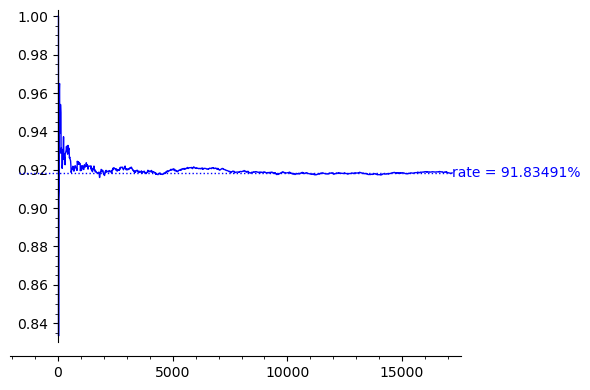

In [380]:
stats = []
G = 0; T = 0
for d in off_diagonal_criterion_data[2]:
    p,g,t = d
    G += g
    T += t
    stats.append([p,G/T])

final_prime, final_rate = stats[-1]
final_rate_percent = QQ(100*final_rate).n(digits=7)

plot_data = line(stats)
asym = line([(-final_prime/10+1, final_rate), (final_prime, final_rate)], linestyle="dotted")
lbl = text(f"rate = {final_rate_percent}%", (final_prime+10, final_rate),horizontal_alignment="left")

(plot_data + asym + lbl).show()

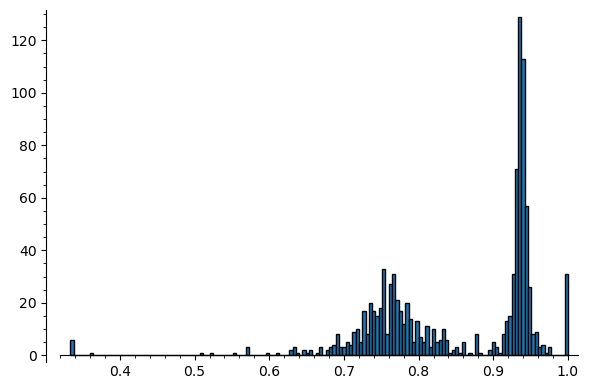

In [391]:
stats = []
for d in off_diagonal_criterion_data[2]:
    p,g,t = d
    stats.append(g/t)

histogram(stats,bins=150).show()

# Scratch

In [114]:
p = 19; print('p =',p)
k = GF(p)
k2 = list(set([t^2 for t in GF(p) if t!=0 and t!=1 and t!=k(-1)])); print('nonzero/one squares:',k2)
for l in k2:
    orbit = [l,1/l,1-l,1/(1-l),l/(l-1),(l-1)/l]
    print('orbit of',l,':',orbit)

ssings = ss_lambdas(p); print('ssing lambdas:',ssings)
for l in ssings:
    orbit = [l,1/l,1-l,1/(1-l),l/(l-1),(l-1)/l]
    print('orbit of',l,':',orbit)

p = 19
nonzero/one squares: [4, 5, 6, 7, 9, 11, 16, 17]
orbit of 4 : [4, 5, 16, 6, 14, 15]
orbit of 5 : [5, 4, 15, 14, 6, 16]
orbit of 6 : [6, 16, 14, 15, 5, 4]
orbit of 7 : [7, 11, 13, 3, 17, 9]
orbit of 9 : [9, 17, 11, 7, 13, 3]
orbit of 11 : [11, 7, 9, 17, 3, 13]
orbit of 16 : [16, 6, 4, 5, 15, 14]
orbit of 17 : [17, 9, 3, 13, 7, 11]
ssing lambdas: [18, 10, 2]
orbit of 18 : [18, 18, 2, 10, 10, 2]
orbit of 10 : [10, 2, 10, 2, 18, 18]
orbit of 2 : [2, 10, 18, 18, 2, 10]


In [119]:
for p in first_primes_3mod4(10):
    print('----------------------------')
    print('p =',p)
    k = GF(p)
    ssings = ss_lambdas(p)
    for l in ssings:
        print(l,'has j-invariant =',k(2^8*(l^2-l+1)^3*l^(-2)*(1-l)^(-2)))
        orbit = [l,1/l,1-l,1/(1-l),l/(l-1),(l-1)/l]
        print('orbit of',l,':',orbit)

----------------------------
p = 7
6 has j-invariant = 6
orbit of 6 : [6, 6, 2, 4, 4, 2]
4 has j-invariant = 6
orbit of 4 : [4, 2, 4, 2, 6, 6]
2 has j-invariant = 6
orbit of 2 : [2, 4, 6, 6, 2, 4]
----------------------------
p = 11
10 has j-invariant = 1
orbit of 10 : [10, 10, 2, 6, 6, 2]
6 has j-invariant = 1
orbit of 6 : [6, 2, 6, 2, 10, 10]
2 has j-invariant = 1
orbit of 2 : [2, 6, 10, 10, 2, 6]
----------------------------
p = 19
18 has j-invariant = 18
orbit of 18 : [18, 18, 2, 10, 10, 2]
10 has j-invariant = 18
orbit of 10 : [10, 2, 10, 2, 18, 18]
2 has j-invariant = 18
orbit of 2 : [2, 10, 18, 18, 2, 10]
----------------------------
p = 23
22 has j-invariant = 3
orbit of 22 : [22, 22, 2, 12, 12, 2]
21 has j-invariant = 19
orbit of 21 : [21, 11, 3, 8, 16, 13]
16 has j-invariant = 19
orbit of 16 : [16, 13, 8, 3, 21, 11]
13 has j-invariant = 19
orbit of 13 : [13, 16, 11, 21, 3, 8]
12 has j-invariant = 3
orbit of 12 : [12, 2, 12, 2, 22, 22]
11 has j-invariant = 19
orbit of 11 : [11

In [118]:
GF(11)(1728)

1